In [0]:
import pandas as pd
import numpy as np
import os
import sys
import sklearn
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook as tqdm

User uploaded file "ACC_AUX.csv" with length 3201698 bytes

User uploaded file "ACCIDENT.csv" with length 5398194 bytes

User uploaded file "CEVENT.csv" with length 2625888 bytes

User uploaded file "DAMAGE.csv" with length 3063538 bytes

User uploaded file "DISTRACT.csv" with length 792596 bytes

User uploaded file "DRIMPAIR.csv" with length 780534 bytes

User uploaded file "DRUGS.csv" with length 1883861 bytes

User uploaded file "FACTOR.csv" with length 765741 bytes

User uploaded file "MANEUVER.csv" with length 795168 bytes

User uploaded file "MIACC.csv" with length 1041740 bytes

User uploaded file "MIDRVACC.csv" with length 1021371 bytes

User uploaded file "MIPER.csv" with length 1998730 bytes

User uploaded file "NMCRASH.csv" with length 180454 bytes

User uploaded file "NMIMPAIR.csv" with length 134464 bytes

User uploaded file "NMPRIOR.csv" with length 135301 bytes

User uploaded file "PARKWORK.csv" with length 267236 bytes

User uploaded file "PBTYPE.csv" with length 462439 bytes

User uploaded file "PER_AUX.csv" with length 4792170 bytes

User uploaded file "PERSON.csv" with length 13256237 bytes

User uploaded file "SAFETYEQ.csv" with length 207131 bytes

User uploaded file "VEH_AUX.csv" with length 2324544 bytes

User uploaded file "VEHICLE.csv" with length 16363292 bytes

User uploaded file "VEVENT.csv" with length 3567752 bytes

User uploaded file "VINDECODE.csv" with length 24128934 bytes

User uploaded file "VIOLATN.csv" with length 811167 bytes

User uploaded file "VISION.csv" with length 761725 bytes

User uploaded file "VSOE.csv" with length 2317084 bytes

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving PERSON.csv to PERSON (1).csv
User uploaded file "PERSON.csv" with length 13256237 bytes


In [0]:
df = pd.read_csv("PERSON.csv") # For on Colab
# df = pd.read_csv("FARS2018NationalCSV\\PERSON.csv") # For local jupyter

In [9]:
df

,STATE,ST_CASE,VE_FORMS,VEH_NO,PER_NO,STR_VEH,COUNTY,DAY,MONTH,HOUR,MINUTE,RUR_URB,FUNC_SYS,HARM_EV,MAN_COLL,SCH_BUS,MAKE,MAK_MOD,BODY_TYP,MOD_YEAR,TOW_VEH,SPEC_USE,EMER_USE,ROLLOVER,IMPACT1,FIRE_EXP,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EJ_PATH,EXTRICAT,DRINKING,ALC_DET,ALC_STATUS,ATST_TYP,ALC_RES,DRUGS,DRUG_DET,DSTATUS,HOSPITAL,DOA,DEATH_DA,DEATH_MO,DEATH_YR,DEATH_HR,DEATH_MN,DEATH_TM,LAG_HRS,LAG_MINS,P_SF1,P_SF2,P_SF3,WORK_INJ,HISPANIC,RACE,LOCATION
0,1,10001,1,1,1,0,121,5,1,6,0,1,1,14,0,0,82.0,82881.0,66.0,2018.0,1.0,0.0,0.0,1.0,12.0,0.0,55,1,1,4,11,20,0,20,2,9,0,0,9,2,1,0,0,8,2,0,7,5,1,2018,6,0,600,0,0,0,0,0,1,7,2,0
1,1,10002,1,1,1,0,127,8,1,0,48,2,1,38,0,0,58.0,58037.0,4.0,9999.0,0.0,0.0,0.0,0.0,12.0,1.0,24,1,1,4,11,20,0,1,1,9,0,9,9,0,0,996,9,8,0,0,7,8,1,2018,0,48,48,0,0,0,0,0,0,7,2,0
2,1,10002,1,1,2,0,127,8,1,0,48,2,1,38,0,0,58.0,58037.0,4.0,9999.0,0.0,0.0,0.0,0.0,12.0,1.0,24,1,2,4,13,3,0,1,0,0,9,8,9,0,0,996,8,8,0,0,7,8,1,2018,0,48,48,0,0,0,0,0,0,7,2,0
3,1,10003,2,1,1,0,21,8,1,22,50,1,1,24,0,0,63.0,63402.0,14.0,2008.0,0.0,0.0,0.0,0.0,11.0,0.0,37,2,1,4,11,20,0,1,0,0,9,0,9,2,1,0,9,8,2,0,7,8,1,2018,22,50,2250,0,0,0,0,0,0,7,1,0
4,1,10003,2,2,1,0,21,8,1,22,50,1,1,24,0,0,7.0,7881.0,61.0,2001.0,0.0,0.0,0.0,0.0,1.0,0.0,36,1,1,2,11,20,0,20,0,0,0,0,9,0,0,996,0,8,0,5,0,88,88,8888,88,88,8888,999,99,0,0,0,8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83621,56,560099,1,1,1,0,1,11,12,18,45,1,1,1,0,0,34.0,34034.0,4.0,1994.0,0.0,0.0,0.0,1.0,0.0,0.0,61,1,1,4,11,20,0,20,2,9,0,9,9,8,95,995,9,8,8,0,7,11,12,2018,18,47,1847,0,2,0,0,0,0,7,2,0
83622,56,560100,1,1,1,0,13,22,10,13,34,1,5,1,0,0,20.0,20036.0,2.0,2002.0,0.0,0.0,0.0,9.0,0.0,0.0,34,2,1,4,11,20,0,1,1,9,0,1,9,8,95,995,1,8,8,5,0,22,10,2018,14,20,1420,0,46,0,0,0,0,7,3,0
83623,56,560100,1,1,2,0,13,22,10,13,34,1,5,1,0,0,20.0,20036.0,2.0,2002.0,0.0,0.0,0.0,9.0,0.0,0.0,36,1,2,2,13,20,0,1,0,0,9,8,9,0,0,996,8,8,0,5,0,88,88,8888,88,88,8888,999,99,0,0,0,8,0,0,0
83624,56,560101,2,1,1,0,13,9,11,18,3,1,5,12,8,0,20.0,20401.0,14.0,1992.0,0.0,0.0,0.0,1.0,11.0,0.0,40,1,1,4,11,20,0,20,1,9,0,1,9,8,95,995,9,8,8,0,7,9,11,2018,18,21,1821,0,18,0,0,0,0,7,3,0


In [0]:
df2 = df[['HOUR','RUR_URB','FUNC_SYS','HARM_EV','MAN_COLL','BODY_TYP','MOD_YEAR','ROLLOVER','IMPACT1','FIRE_EXP','AGE','SEX','SEAT_POS','REST_USE','AIR_BAG','EJECTION','EXTRICAT','INJ_SEV']]
df2.columns = [x.lower() for x in df2.columns]
df2 = df2.rename(columns = {'func_sys':'road_type',
                            'harm_ev':'harm_event',
                            'man_coll':'car_orientation',
                            'body_typ':'body_type',
                            'mod_year':'model_year',
                            'impact1':'impact_area',
                            'fire_exp':'fire',
                            'rest_use':'protection',
                            'air_bag':'airbag',
                            'extricat':'extricated'})
df2 = df2[df2['hour'] < 24]
df2 = df2[df2['rur_urb'] < 3]
df2 = df2[df2['road_type'] < 8]
df2 = df2[df2['harm_event'] < 99]
df2 = df2[df2['car_orientation'] < 11]
df2 = df2[df2['body_type'] < 91]
df2 = df2[df2['model_year'] < 9998]
df2 = df2[df2['impact_area'] < 98]
df2 = df2[df2['age'] < 998]
df2 = df2[df2['sex'] < 8]
df2 = df2[df2['seat_pos'] < 98]
df2 = df2[df2['protection'] < 29]
df2 = df2[df2['airbag'] < 98]
df2 = df2[(df2['ejection'] != 9) & (df2['ejection'] != 7)]
df2 = df2[df2['extricated'] < 9]
df2 = df2[df2['inj_sev'] < 5]
df2['inj_sev'] = df2['inj_sev'].map({0:0,1:1,2:1,3:1,4:2})
df2 = df2.astype('int64')
df2 = df2.reset_index(drop = True)

In [11]:
df2.columns

Index(['hour', 'rur_urb', 'road_type', 'harm_event', 'car_orientation',
       'body_type', 'model_year', 'rollover', 'impact_area', 'fire', 'age',
       'sex', 'seat_pos', 'protection', 'airbag', 'ejection', 'extricated',
       'inj_sev'],
      dtype='object')

In [12]:
df2['inj_sev'].value_counts().sort_index()

0    17336
1    19828
2    22768
Name: inj_sev, dtype: int64

In [0]:
dummy_df = pd.get_dummies(df2, columns=['rur_urb','road_type','harm_event','car_orientation','body_type','rollover','impact_area','seat_pos','protection','airbag', 'ejection'], drop_first=True)

In [14]:
dummy_df

,hour,model_year,fire,age,sex,extricated,inj_sev,rur_urb_2,road_type_2,road_type_3,road_type_4,road_type_5,road_type_6,road_type_7,harm_event_2,harm_event_3,harm_event_5,harm_event_6,harm_event_7,harm_event_8,harm_event_9,harm_event_10,harm_event_11,harm_event_12,harm_event_14,harm_event_15,harm_event_16,harm_event_17,harm_event_18,harm_event_19,harm_event_20,harm_event_21,harm_event_23,harm_event_24,harm_event_25,harm_event_26,harm_event_30,harm_event_31,harm_event_32,harm_event_33,...,seat_pos_22,seat_pos_23,seat_pos_28,seat_pos_29,seat_pos_31,seat_pos_32,seat_pos_33,seat_pos_38,seat_pos_39,seat_pos_41,seat_pos_42,seat_pos_43,seat_pos_50,seat_pos_51,seat_pos_52,seat_pos_53,seat_pos_54,seat_pos_55,protection_2,protection_3,protection_4,protection_5,protection_8,protection_10,protection_11,protection_12,protection_16,protection_17,protection_19,protection_20,airbag_2,airbag_3,airbag_7,airbag_8,airbag_9,airbag_20,ejection_1,ejection_2,ejection_3,ejection_8
0,6,2018,0,55,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1,22,2001,0,36,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,13,2004,0,58,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,13,2004,0,26,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
4,7,2016,0,46,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59927,10,2000,0,44,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
59928,10,2014,0,63,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
59929,18,1994,0,61,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
59930,13,2002,0,34,2,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [0]:
Xcols = dummy_df.columns.tolist()
Xcolstot = df2.columns.tolist()

In [0]:
Xcols.remove('inj_sev')
Xcolstot.remove('inj_sev')

In [0]:
Xtot = df2[Xcolstot].values
ytot = df2['inj_sev'].values

X = dummy_df[Xcols].values
y = dummy_df['inj_sev'].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = .2, stratify=y, random_state = 50)

In [0]:
pca = PCA(n_components=50)
pca.fit_transform(Xtrain)
feature_pca = pca.transform(Xtrain)

In [0]:
feature_pca

array([[ 1.41604316e+01,  9.03558187e+00, -8.35506300e+00, ...,
        -1.69309130e-01,  6.66298722e-01,  2.14990906e-01],
       [-5.83187973e+00,  4.03912022e+00, -9.58794497e+00, ...,
        -7.60834825e-02, -6.44933295e-02,  3.58703119e-01],
       [-1.08127578e+01, -6.02833871e+00, -9.02472173e+00, ...,
         1.73965866e-02,  5.89709954e-02,  2.07757162e-01],
       ...,
       [ 1.31838313e+01, -9.15313094e+00, -4.11327302e+00, ...,
        -4.44679658e-02,  2.82895767e-02, -1.53433487e-02],
       [-2.38262281e+01, -2.11319804e+00, -6.85755083e+00, ...,
         9.36874963e-01,  5.66851702e-02, -1.69775364e-02],
       [-1.82384386e+00, -6.32829154e+00, -1.02008643e+00, ...,
        -3.29649201e-02, -8.46823727e-02, -8.34287711e-03]])

In [0]:
model = LinearSVC(C = .1, verbose=99)
# pipe_steps = [('pca',PCA(n_components=10)), ('linearsvc',LinearSVC())]

# check_params = {
#     'pca__n_components': [8,10,12],
#     'linearsvc__C': [.1, .5, 1, 10, 20, 30, 40, 50, 75, 100, 500, 1000]
# }
# pipeline = Pipeline(pipe_steps)
scores = sklearn.model_selection.cross_val_score(model, feature_pca, ytrain, cv=5, verbose = 99, scoring='f1_micro', n_jobs=-1)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Memmapping (shape=(47945, 50), dtype=float64) to new file C:\Users\ericm\AppData\Local\Temp\joblib_memmapping_folder_13624_8896934793\13624-2726572616336-f89f2dba7a7d42dd8ee72290d0f80516.pkl
Pickling array (shape=(47945,), dtype=int64).
Pickling array (shape=(38355,), dtype=int32).
Pickling array (shape=(9590,), dtype=int32).
Memmapping (shape=(47945, 50), dtype=float64) to old file C:\Users\ericm\AppData\Local\Temp\joblib_memmapping_folder_13624_8896934793\13624-2726572616336-f89f2dba7a7d42dd8ee72290d0f80516.pkl
Pickling array (shape=(47945,), dtype=int64).
Pickling array (shape=(38355,), dtype=int32).
Pickling array (shape=(9590,), dtype=int32).
Memmapping (shape=(47945, 50), dtype=float64) to old file C:\Users\ericm\AppData\Local\Temp\joblib_memmapping_folder_13624_8896934793\13624-2726572616336-f89f2dba7a7d42dd8ee72290d0f80516.pkl
Pickling array (shape=(47945,), dtype=int64).
Pickling array (shape=(38356,),

In [0]:
# create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=5, scoring = 'accuracy')
# create_grid.fit(Xtrain, ytrain)
# print(create_grid.score(Xtest, ytest))
# print(create_grid.best_params_)

.5,10 = .57 +- .01

.5,15 = .58 +- .01

.5,30 = .60 +- .02

.1,30 = .61 +- .00

.1,20 = .60 +- .01

.1,50 = .62 +- .00

.1,None = .63 +- .01

.5,20 = .65 +- .02




.1,50 = .70 +- .01

.1,None .71 +- .00

.5,50 .71 .02


In [0]:
import statsmodels.api as sm

model = sm.GLM(dummy_df['inj_sev'].values, dummy_df[[x for x in dummy_df.columns if x != 'inj_sev']].values, axis = 1, family=sm.families.Binomial())

results = model.fit()

print(results.summary())

C:\Users\ericm\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\genmod\families\family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\ericm\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\genmod\families\family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\ericm\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\genmod\families\links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\ericm\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\genmod\families\family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\ericm\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\genmod\families\family.py:889: RuntimeWarning: invalid value encountered in true

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                59932
Model:                            GLM   Df Residuals:                    59734
Model Family:                Binomial   Df Model:                          197
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 14 Nov 2019   Deviance:                          nan
Time:                        16:16:53   Pearson chi2:                 1.48e+20
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -5.335e+14   4.35e+04  -1.23e+10      0.0

In [0]:
type(results.summary())

statsmodels.iolib.summary.Summary

In [0]:
from functools import partial
from sklearn.feature_selection import mutual_info_classif, SelectKBest
discrete_feat_idx = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] # an array with indices of discrete features
score_func = partial(mutual_info_classif, discrete_features=discrete_feat_idx)
tot_scores = []
for a in range(13, 14):
    s = SelectKBest(score_func, k=a)
    s.fit_transform(Xtot, ytot)

    cols = s.get_support(indices=True)
    cols

    Xsel = df2.iloc[:, cols]
    # Xsel = Xtot[:, cols]

    cat_vars = ['rur_urb','road_type','harm_event','car_orientation','body_type','rollover','impact_area','seat_pos','protection','airbag', 'ejection', 'age']

    Xsel = pd.get_dummies(Xsel, columns=[x for x in Xsel.columns if x in cat_vars], drop_first=True)
    Xsel = Xsel.values
    Xsel.shape

    model = LinearSVC(C = .1, verbose=1)
    
    pca = PCA(n_components=90)
    pca.fit_transform(Xsel)
    feature_pca = pca.transform(Xsel)
    
    tot_scores.append(sklearn.model_selection.cross_val_score(model, Xsel, ytot, cv=5, verbose = 1, scoring='accuracy', n_jobs=-1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5

In [0]:
for i in range(len(tot_scores)):
    print("k = %i: Accuracy: %0.2f (+/- %0.2f)" % (i + 7, tot_scores[i].mean(), tot_scores[i].std() * 2))

k = 7: Accuracy: 0.69 (+/- 0.04)
k = 8: Accuracy: 0.69 (+/- 0.05)
k = 9: Accuracy: 0.69 (+/- 0.05)
k = 10: Accuracy: 0.71 (+/- 0.05)
k = 11: Accuracy: 0.70 (+/- 0.04)
k = 12: Accuracy: 0.58 (+/- 0.13)
k = 13: Accuracy: 0.47 (+/- 0.13)


In [0]:
for i in range(len(tot_scores)):
    print("k = %i: Accuracy: %0.2f (+/- %0.2f)" % (i + 7, tot_scores[i].mean(), tot_scores[i].std() * 2))

k = 7: Accuracy: 0.68 (+/- 0.05)
k = 8: Accuracy: 0.68 (+/- 0.05)
k = 9: Accuracy: 0.68 (+/- 0.05)
k = 10: Accuracy: 0.69 (+/- 0.04)
k = 11: Accuracy: 0.70 (+/- 0.04)
k = 12: Accuracy: 0.70 (+/- 0.04)
k = 13: Accuracy: 0.70 (+/- 0.04)


In [0]:
tot_scores = []
discrete_feat_idx = [1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16] # an array with indices of discrete features
score_func = partial(mutual_info_classif, discrete_features=discrete_feat_idx)
s = SelectKBest(score_func, k=13)
s.fit_transform(Xtot, ytot)

cols = s.get_support(indices=True)
cols

Xsel = df2.iloc[:, cols]
# Xsel = Xtot[:, cols]
Xsel['age'] = Xsel['age'].map({x:0 if x < 18 else 1 if x < 65 else 2 for x in range(Xsel['age'].max())})

cat_vars = ['rur_urb','road_type','harm_event','car_orientation','body_type','rollover','impact_area','seat_pos','protection','airbag', 'ejection', 'age']

Xsel = pd.get_dummies(Xsel, columns=[x for x in Xsel.columns if x in cat_vars], drop_first=True)
Xsel = Xsel.values
Xsel.shape

model = LinearSVC(C = .1, verbose=1)

#     pca = PCA(n_components=90)
#     pca.fit_transform(Xsel)
#     feature_pca = pca.transform(Xsel)

tot_scores.append(sklearn.model_selection.cross_val_score(model, Xsel, ytot, cv=5, verbose = 1, scoring='accuracy', n_jobs=-1))

C:\Users\ericm\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


<function matplotlib.pyplot.show>

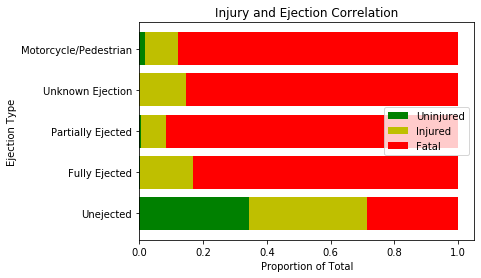

In [18]:
from functools import partial
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from matplotlib import pyplot as plt

discrete_feat_idx = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16] # an array with indices of discrete features
score_func = partial(mutual_info_classif, discrete_features=discrete_feat_idx)

s = SelectKBest(score_func, k=1)
s.fit_transform(Xtot, ytot)

cols = [15]
cols2 = np.append(cols, 17)
Xsel = df2.iloc[:, cols2]
values = df2.ejection.unique()
values.sort()
values

uninjured = []
injured = []
fatal = []
for value in values:
  uninjured.append(Xsel[(Xsel['ejection'] == value) & (Xsel['inj_sev'] == 0)].shape[0]/Xsel[(Xsel['ejection'] == value)].shape[0])
  injured.append(Xsel[(Xsel['ejection'] == value) & (Xsel['inj_sev'] == 1)].shape[0]/Xsel[(Xsel['ejection'] == value)].shape[0])
  fatal.append(Xsel[(Xsel['ejection'] == value) & (Xsel['inj_sev'] == 2)].shape[0]/Xsel[(Xsel['ejection'] == value)].shape[0])

index = np.arange(5)
p1 = plt.barh(index, uninjured, color='g')
p2 = plt.barh(index, injured, left=uninjured, color='y')
p3 = plt.barh(index, fatal, left=np.asarray(injured)+np.asarray(uninjured), color='red')

plt.xlabel('Proportion of Total')
plt.ylabel('Ejection Type')
plt.title('Injury and Ejection Correlation')
plt.yticks(index, ('Unejected', 'Fully Ejected', 'Partially Ejected', 'Unknown Ejection', 'Motorcycle/Pedestrian'))
plt.legend((p1[0], p2[0], p3[0]), ('Uninjured', 'Injured', 'Fatal'))

plt.show

<function matplotlib.pyplot.show>

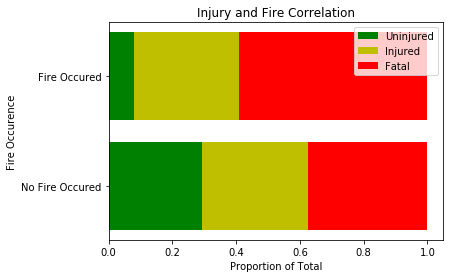

In [22]:
cols = [9]
cols2 = np.append(cols, 17)
Xsel = df2.iloc[:, cols2]
values = df2.fire.unique()
values.sort()
values

uninjured = []
injured = []
fatal = []
for value in values:
  uninjured.append(Xsel[(Xsel['fire'] == value) & (Xsel['inj_sev'] == 0)].shape[0]/Xsel[(Xsel['fire'] == value)].shape[0])
  injured.append(Xsel[(Xsel['fire'] == value) & (Xsel['inj_sev'] == 1)].shape[0]/Xsel[(Xsel['fire'] == value)].shape[0])
  fatal.append(Xsel[(Xsel['fire'] == value) & (Xsel['inj_sev'] == 2)].shape[0]/Xsel[(Xsel['fire'] == value)].shape[0])

index = np.arange(2)
p1 = plt.barh(index, uninjured, color='g')
p2 = plt.barh(index, injured, left=uninjured, color='y')
p3 = plt.barh(index, fatal, left=np.asarray(injured)+np.asarray(uninjured), color='red')

plt.xlabel('Proportion of Total')
plt.ylabel('Fire Occurence')
plt.title('Injury and Fire Correlation')
plt.yticks(index, ('No Fire Occured', 'Fire Occured'))
plt.legend((p1[0], p2[0], p3[0]), ('Uninjured', 'Injured', 'Fatal'))

# plt.tight_layout()
plt.show

In [84]:
s = SelectKBest(score_func, k=16)
s.fit_transform(Xtot, ytot)
cols = s.get_support(indices=True)
print(cols)

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16]


In [89]:
s = SelectKBest(score_func, k=17)
s.fit_transform(Xtot, ytot)
cols = s.get_support(indices=True)
print(cols)
# df2.ejection.value_counts()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
